In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jacobian
from getdist import MCSamples, plots

from tqdm import tqdm

import sys
sys.path.append("../")

from pldflow import plflow

import os
import jax
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Fresnel(plflow.PicardLefschetzModelBaseClass):
    ndim = 5
    def action_s(self, z, y, p=1):
        return 1j*jnp.dot(z, z) - 2j*jnp.dot(z, y)

## $n$ D

In [6]:
fresnel = Fresnel()

In [7]:
priors = {'x':(-7,7,fresnel.ndim), 'y':(-5,5,fresnel.ndim)}
sampler = plflow.HMCSampler(fresnel, priors)

In [8]:
t = jnp.linspace(0, 0.4, 100)
sampler.sample(num_samples=10000, t=t)

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
  0%|          | 0/10500 [00:00<?, ?it/s]/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [00:18<00:00, 568.72it/s, 15 steps of size 2.34e-01. acc. prob=0.85]


In [9]:
mcs = sampler.get_samples(format=MCSamples)

Removed no burn in


<Figure size 400x400 with 0 Axes>

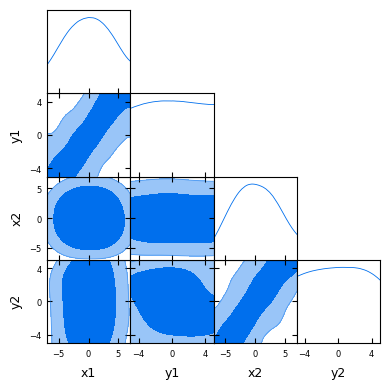

In [10]:
g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1', 'x2', 'y2'], filled=True)
plt.show()

In [13]:
maf = plflow.MAFModel(sampler)

In [18]:
maf.build(hidden_dims=[64,64,64], n_transforms=8)

In [20]:
%time maf.train(n_steps=1_000, batch_size=128)

Training MAF: 100%|██████████| 1000/1000 [00:43<00:00, 23.23it/s]

CPU times: user 42.4 s, sys: 2.37 s, total: 44.8 s
Wall time: 44.1 s


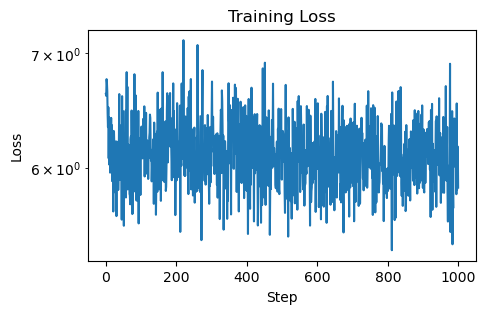

In [21]:
maf.plot_loss()

In [25]:
y = jnp.array([4.0]+[0.0]*(fresnel.ndim-1))
%time x = maf.sample(y, num_samples=5000, seed=5)
%time lnp = maf.log_prob(x, y)

CPU times: user 1.51 s, sys: 43.7 ms, total: 1.56 s
Wall time: 1.54 s
CPU times: user 1.57 s, sys: 105 ms, total: 1.68 s
Wall time: 1.57 s


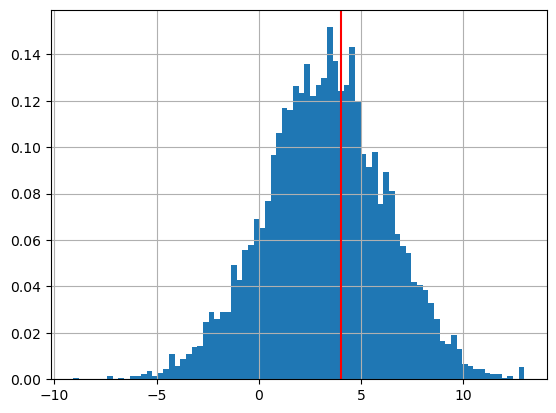

In [26]:
a = jnp.argsort(x[:,0])
plt.hist(x[a,0], bins=80, density=True)
# plt.plot(x[a,0], jnp.exp(lnp[a]))
plt.axvline(y[0], color='r')
plt.grid()
plt.show()

In [28]:
y1 = jnp.linspace(-3, 3, 100)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)

Z = []
for _y in tqdm(y):
    x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [03:40<00:00,  2.21s/it]


In [29]:
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y1**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

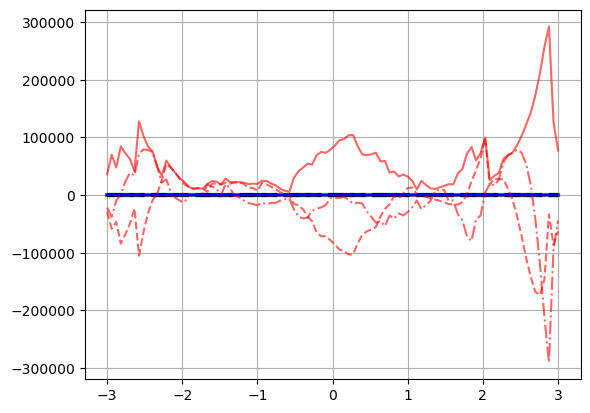

In [30]:
# analytic
plt.plot(y1, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y1, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y1, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y1, jnp.real(Z), color='r', ls='--', alpha=0.6)
plt.plot(y1, jnp.imag(Z), color='r', ls='-.', alpha=0.6)
plt.plot(y1, jnp.abs(Z) , color='r', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y1, jnp.real(Z)/norm, color='b', ls='--')
plt.plot(y1, jnp.imag(Z)/norm, color='b', ls='-.')
plt.plot(y1, jnp.abs(Z) /norm, color='b', ls='-')
plt.grid()
plt.show()